# Youtube Views Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import plotly.express as px
import missingno as msno
warnings.filterwarnings('ignore')

%matplotlib inline

# Load and Describe Data

-----

## Load Data

In [2]:
dfraw = pd.read_excel('youtube_statistics.xlsx')
dfraw.sample(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date
13419,2018-01-27,LOVE Marriage Ke Side Effects 2 l Miya Biwi Ta...,The Baigan Vines Official,24,10:42:43,"ashish|""chanchlani""|""hyderabadi""|""jokes""|""bb""|...",101892,8780,233,979,False,False,False,Check out some of the common side effects ever...,44,809,69,2018-01-26
9744,2018-01-05,ലൈവില്‍ കിടിലന്‍ ലുക്ക്‌ പരീക്ഷിച്ച് ടോവിനോ - ...,filmmatter,1,16:11:11,"filmmatter|""Tovino Thomas""|""tovino""|""thomas""|""...",49114,426,22,39,False,False,False,Like our Facebook page\nhttps://www.facebook.c...,10,236,96,2018-01-03
25770,2018-04-15,Types Of Phone Users You'll Meet | Hasley India,Hasley India,23,13:55:13,"hasley|""india""|""harsh""|""beniwal""|""rishhsome""|""...",635753,27564,3385,1228,False,False,False,We are back with a new comedy sketch on the ty...,32,1022,47,2018-04-13
18780,2018-02-27,"Sridevi R.I.P Lifestyle, House, Net Worth, Boy...",Univrsal Media Pro,22,05:34:48,"Sridevi Kapoor Lifestyle|""Sridevi Biography""|""...",612631,1152,383,79,False,False,False,"Sridevi R.I.P Lifestyle, House, Net Worth, Boy...",25,1444,98,2018-02-25
30794,2018-05-12,#Mahanati (Savitri Biopic) Director Nag Ashwin...,iDream Telugu Movies,24,12:00:34,"#Mahanati|""Director Nag Ashwin Interview""|""Nag...",183952,1187,100,249,False,False,False,Here's the exclusive interview of #Mahanati (S...,18,1639,87,2018-05-10


Fitur pada dataset :

● `trending_date`: tanggal ketika video trending  
● `title`: judul video  
● `channel_title`: nama channel  
● `category_id`: kategori video dalam label encoding  
● `publish_time`: waktu publish video  
● `tags`: tag yang digunakan pada video  
● `views`: jumlah views video  
● `likes`: jumlah likes video  
● `dislikes`: jumlah dislikes video  
● `comment_count`: jumlah komentar pada video  
● `comments_disabled`: apakah status komentar dinonaktifkan pada video  
● `ratings_disabled`: apakah rating dinonaktifkan pada video  
● `video_error_or_removed`: apakah video error atau sudah dihapus saat ini  
● `description`: deskripsi video  
● `No_tags`: jumlah tags yang digunakan  
● `desc_len`: panjang kata deskripsi video  
● `len_title`: panjang kata judul video  
● `publish_date`: tanggal publish video  

## Data Exploration

In [3]:
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           36791 non-null  object        
 1   title                   36791 non-null  object        
 2   channel_title           36791 non-null  object        
 3   category_id             36791 non-null  int64         
 4   publish_time            36791 non-null  object        
 5   tags                    36791 non-null  object        
 6   views                   36791 non-null  int64         
 7   likes                   36791 non-null  int64         
 8   dislikes                36791 non-null  int64         
 9   comment_count           36791 non-null  int64         
 10  comments_disabled       36791 non-null  bool          
 11  ratings_disabled        36791 non-null  bool          
 12  video_error_or_removed  36791 non-null  bool  

1. Terdapat 36.791 entries  
2. Kolom `trending_date` dan `publish_time` bisa diubah tipe data nya untuk menyesuaikan dengan data.
3. Kolom `No_tags` sebaiknya diubah menjadi lower case agar memudahkan penyebutan variabel.

In [4]:
# Mengubah nama kolom menjadi lower case
dfraw.columns = dfraw.columns.str.lower()

In [5]:
# Mengecek null value
dfraw.isnull().sum()

trending_date              0
title                      0
channel_title              0
category_id                0
publish_time               0
tags                       0
views                      0
likes                      0
dislikes                   0
comment_count              0
comments_disabled          0
ratings_disabled           0
video_error_or_removed     0
description               45
no_tags                    0
desc_len                   0
len_title                  0
publish_date               0
dtype: int64

Only one column has null value. Amazing!  
Karena kolom yang memiliki null value adalah 'description'. Maka, tidak perlu handling null value karena nantinya kolom ini tidak akan digunakan untuk pemodelan.

In [6]:
# Mengecek duplicated rows
dfraw.duplicated().sum()

4229

Dataset kita ternyata memiliki banyak sekali duplicated rows.

In [7]:
# Mengkategorikan fitur sesuai dari tipe data
num = ['category_id','views', 'likes', 'dislikes', 'comment_count', 'no_tags', 'desc_len', 'len_title']
cat = ['trending_date', 'channel_title','publish_time', 'tags', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed']

# Membatasi angka setelah koma hingga hanya 3 angka
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dfraw[num].describe()

,category_id,views,likes,dislikes,comment_count,no_tags,desc_len,len_title
count,36791.000,36791.000,36791.000,36791.000,36791.000,36791.000,36791.000,36791.000
mean,21.552,1071490.259,27450.694,1685.363,2714.022,18.938,923.079,70.609
std,6.587,3207149.048,97831.295,16197.317,14978.114,9.844,815.039,22.409
min,1.000,4024.000,0.000,0.000,0.000,1.000,3.000,5.000
25%,23.000,125604.000,879.000,109.000,83.000,12.000,368.000,53.000
50%,24.000,307836.000,3126.000,331.000,336.000,19.000,677.000,74.000
75%,24.000,806631.500,14095.000,1032.000,1314.500,25.000,1237.000,91.000
max,43.000,125432237.000,2912710.000,1545017.000,827755.000,72.000,5136.000,100.000


Notes :  

1. Fitur numerical tidak ada null value.  
2. Nilai min-max nya terlampau ekstrem, kecuali pada `no_tags` dan `len_title` yang mungkin masih masuk akal.  
3. Nilai mean-median pada fitur `views`, `likes`, `dislikes`, dan `comment_count` sangat jauh. Hal ini mungkin disebabkan ada beberapa video yang trending.  
4. Perlu dilakukan pengecekan fitur pada nilai-nilai ekstrem

In [8]:
dfraw[cat].describe()

,trending_date,channel_title,publish_time,tags,comments_disabled,ratings_disabled,video_error_or_removed
count,36791,36791,36791,36791,36791,36791,36791
unique,205,1390,12375,12463,2,2,2
top,2017-12-23,VikatanTV,04:30:00,[none],False,False,False
freq,199,284,333,1120,35611,36034,36780


1. Pada kolom `tags` tidak terdapat value yang paling sering muncul. Hal ini mungkin disebabkan oleh beragam jenis penulisan tag.   
2. Kita bisa melihat bahwa tidak banyak video yang komen nya dibatasi atau rating dibatasi atau video yg error maupun dihapus. Terlihat dari hampir semua value bernilai False.  

------

# Exploratory Data Analysis

-------

## Univariate Analysis

### Unique Value From Features

Pada tahap awal inisiasi, kami mengecek beberapa fitur untuk melihat unique value nya sehingga bisa memberikan gambaran awal terkait fitur tersebut.

In [9]:
dfraw['category_id'].unique()

array([ 1, 25, 24, 23, 10, 22, 19, 28, 27, 26, 43, 17, 29,  2, 15, 20, 30],
      dtype=int64)

`category_id` dimulai dari angka 1-43. Yang unik nya adalah kategori ini tidak berurutan.

In [10]:
dfraw['title'].sample(5)

11218    வாணி ராணி - VAANI RANI -  Episode 1467 - 12/01...
35299    Shillong Curfew - Unrest between Dalit Sikhs V...
10540    Agnyaathavaasi Public Talk | Pawan Kalyan Fans...
18409    पहिल्यांदाच राज ठाकरेंचे तुफान प्रश्न!शरद पवार...
28682    Sudigaali Sudheer Performance | Extra Jabardas...
Name: title, dtype: object

`title` dari video-video youtube ini sepertinya berasal dari youtuber di India, terlihat banyak tulisan Hindi. Dari sampel diatas juga terlihat bahwa banyak ketidakseragaman, mulai dari bahasa yang berbeda, lower/upper case, panjang judul, dll.

In [11]:
dfraw['trending_date'].sample(5)

11085    2018-01-14
4420     2017-12-07
27332    2018-04-23
17954    2018-02-22
17129    2018-02-17
Name: trending_date, dtype: object

In [12]:
dfraw['channel_title'].sample(5)

22320    Oneindia Tamil | ஒன்இந்தியா தமிழ்
20710                           First Show
10959                     Telugu Filmnagar
14763                             THIRU TV
26585                      My Village Show
Name: channel_title, dtype: object

In [13]:
dfraw['tags'].sample(5)

23011    Posani Krishna Murali|"Posani"|"Krishna Murali...
32498    dandupalyam 3|"dandupalyam 3 full movie"|"dand...
12393    Zee Yuva|"Phulpakhru"|"full episode"|"Marathi"...
35777    nehakakkar|"tonykakkar"|"sonukakkar"|"neha kak...
24307    Mallemalatv|"Comedy Videos in Telugu"|"All Tim...
Name: tags, dtype: object

Pada kolom `channel_title` dan `tags` juga terlihat beragam macam value nya.

### Outliers

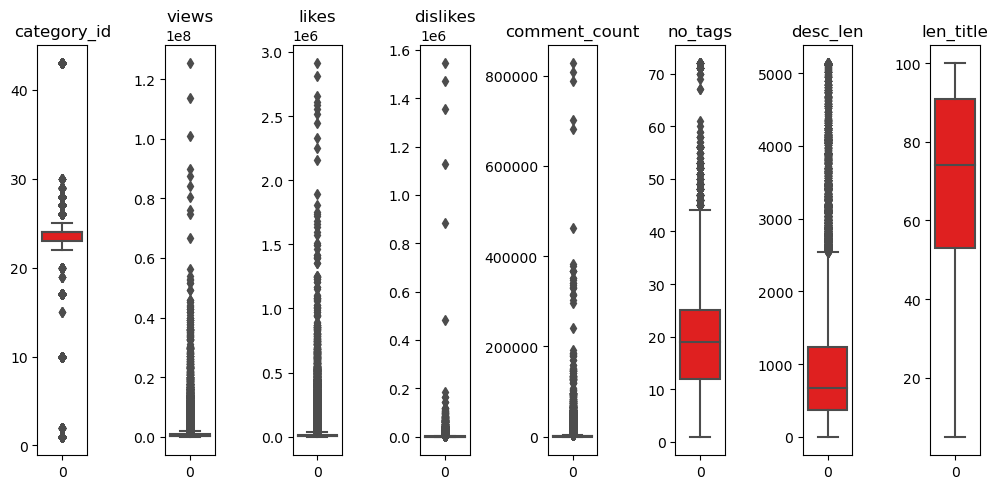

In [14]:
# Melihat penampilan outlier

plt.figure(figsize=(10, 5))
for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(dfraw[num[i]], color='red', orient='v')
    plt.title(num[i])
    plt.tight_layout()

Hampir semua kolom pada fitur numerik memiliki outliers yang ekstrem.

### Distribusi Data

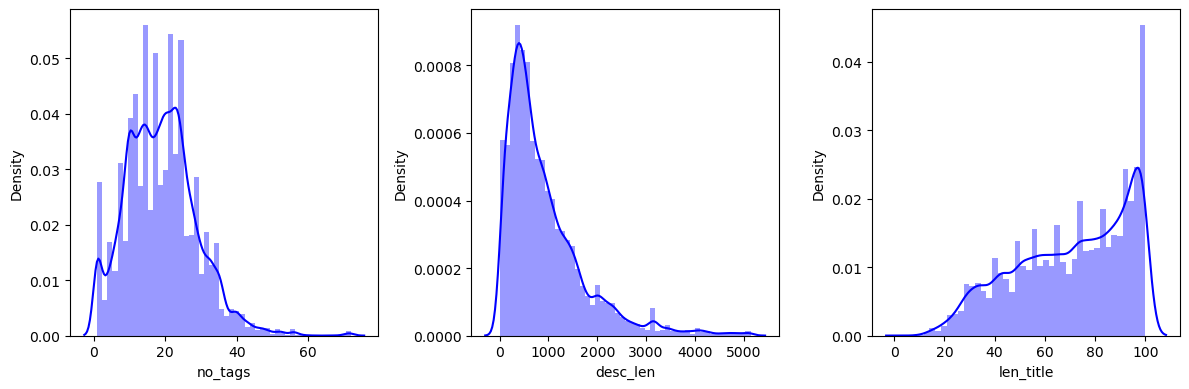

In [15]:
# Melihat grafik distribusi
sub1 = ['no_tags', 'desc_len', 'len_title']

plt.figure(figsize=(12, 4))
for i in range(0, len(sub1)):
    plt.subplot(1, 3, i+1)
    sns.distplot(dfraw[sub1[i]], color='blue')
    plt.tight_layout()

Kolom `no_tags` memiliki distribusi data yang paling baik diantara ketiganya diatas.  
Kolom `desc_len` termasuk right-skewed sedangkan kolom `len_title` kebalikannya yaitu left-skewed.

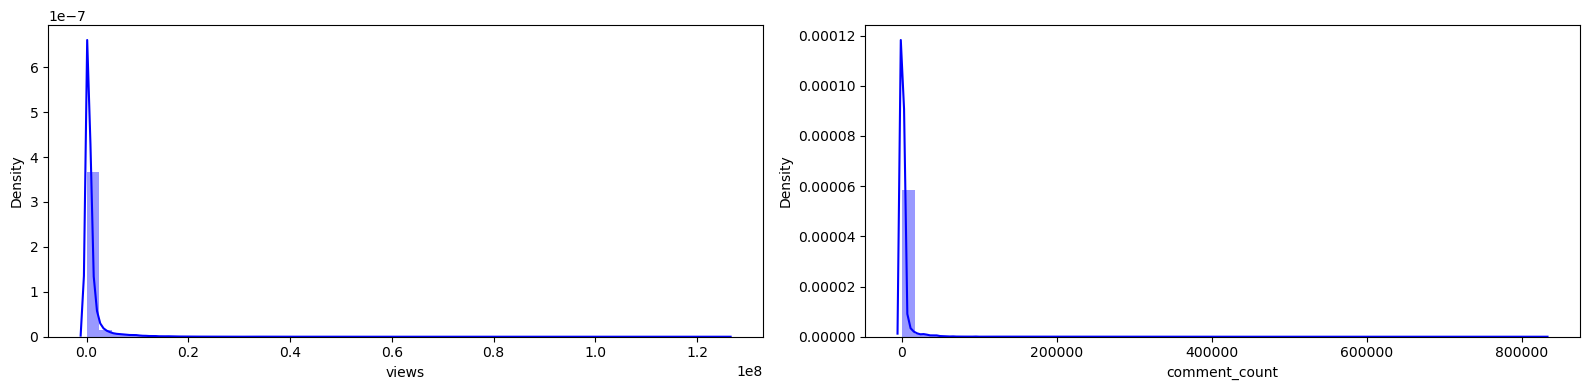

In [16]:
# Melihat grafik distribusi
sub2 = ['views', 'comment_count']

plt.figure(figsize=(16, 4))
for i in range(0, len(sub2)):
    plt.subplot(1, 2, i+1)
    sns.distplot(dfraw[sub2[i]], color='blue')
    plt.tight_layout()

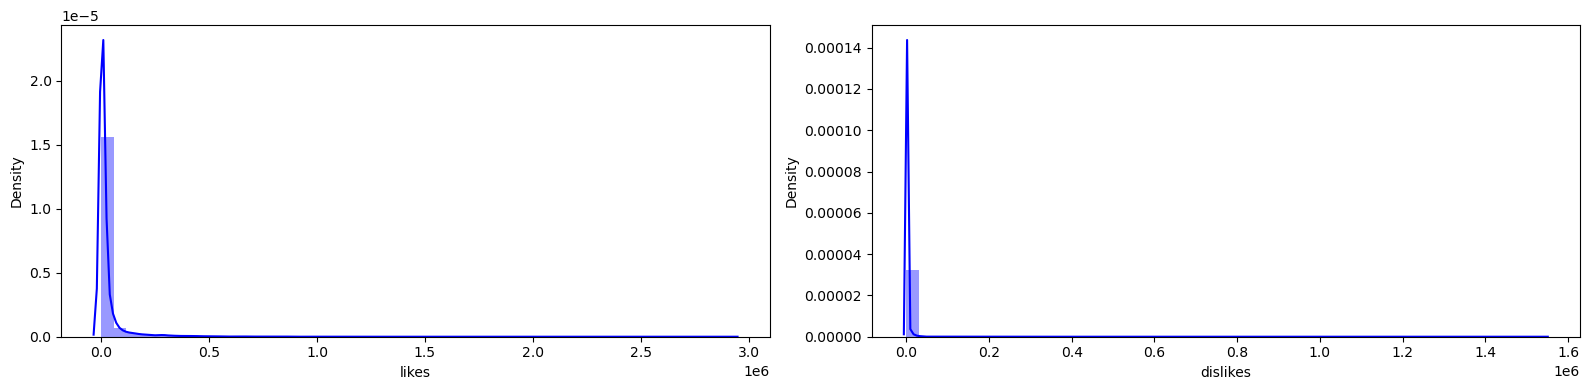

In [17]:
# Melihat grafik distribusi
sub3 = ['likes', 'dislikes']

plt.figure(figsize=(16, 4))
for i in range(0, len(sub3)):
    plt.subplot(1, 2, i+1)
    sns.distplot(dfraw[sub3[i]], color='blue')
    plt.tight_layout()

Grafik dari fitur 'views', 'comment_count', 'likes', dan 'dislikes' menunjukkan distribusi data yang sangat tidak wajar yang terlihat dari grafik yang runcing sekali.

In [18]:
from scipy.stats import kurtosis
print(f"Kurtosis Co-efficient Likes: {round(dfraw.likes.kurtosis(), 3)}")
print(f"Kurtosis Co-efficient Dislikes: {round(dfraw.dislikes.kurtosis(), 3)}")
print(f"Kurtosis Co-efficient Views: {round(dfraw.views.kurtosis(), 3)}")
print(f"Kurtosis Co-efficient Comment Count: {round(dfraw.comment_count.kurtosis(), 3)}")

Kurtosis Co-efficient Likes: 193.855
Kurtosis Co-efficient Dislikes: 6294.719
Kurtosis Co-efficient Views: 254.932
Kurtosis Co-efficient Comment Count: 1110.641


Kurtosis leptokurtic. Tingkat kurtosis nya sangat tinggi. Hal ini mungkin disebabkan oleh outliers yang ekstrim namun wajar dalam dunia trending youtube (bukan input error).

### Check Ekstrem Value

Jika dilihat dari grafik, yang menunjukkan outliers adalah jumlah 'views' mulai dari 4 jutaan keatas.

In [19]:
# Mengecek baris dengan jumlah views tertinggi
extreme= dfraw.sort_values(['views'], ascending = False).reset_index(drop='index')
extreme.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,no_tags,desc_len,len_title,publish_date
0,2017-12-12,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,17:58:51,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",125432237,2912710,1545017,807558,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",37,710,50,2017-12-06
1,2017-12-11,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,17:58:51,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",113876217,2811216,1470387,787174,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",37,710,50,2017-12-06
2,2017-12-10,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,17:58:51,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",100911567,2656672,1353650,682890,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",37,710,50,2017-12-06
3,2017-12-07,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,13:26:24,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",89930713,2606663,53011,347982,False,False,False,There was an idea… Avengers: Infinity War. In ...,11,448,55,2017-11-29
4,2017-12-06,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,13:26:24,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",87449453,2584674,52176,341571,False,False,False,There was an idea… Avengers: Infinity War. In ...,11,448,55,2017-11-29


Video "YouTube Rewind: The Shape of 2017" yang dipublikasikan oleh saluran "YouTube Spotlight" menjadi video dengan view terbanyak, dengan jumlah views sebanyak 125,432,237.

Faktor yang mungkin menjelaskan mengapa video ini memiliki jumlah views yang sangat tinggi: Video ini adalah bagian dari seri tahunan "YouTube Rewind" yang dirilis oleh saluran resmi YouTube. Video ini biasanya merangkum dan memperingati konten populer dan peristiwa yang terjadi selama tahun tersebut di platform YouTube. Karena ini adalah video resmi dari YouTube sendiri, banyak pengguna yang tertarik untuk melihat bagaimana YouTube merangkum peristiwa tahun tersebut.

In [20]:
# Mengecek baris dengan jumlah views terendah
extreme= dfraw.sort_values(['views'], ascending = True).reset_index(drop='index')
extreme.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,no_tags,desc_len,len_title,publish_date
0,2018-05-01,"Baapmanus - बापमाणूस - Episode 118 - May 01, ...",Zee Yuva,24,23:28:11,"Zee Yuva|""Baapmanus""|""full episode""|""Marathi""|...",4024,15,0,0,False,False,False,"To watch FULL episode of Baapmanus, CLICK here...",10,1001,60,2018-04-30
1,2018-05-01,रट लो//1 मई 2018 Current Affairs PDF and Quiz...,Golden Era Education,27,02:15:08,[none],4287,312,12,100,False,False,False,download today pdf- https://www.goldeneraeduca...,1,84,100,2018-05-01
2,2018-03-06,Madhuban Murli LIVE - 6/3/2018 (Tuesday 7.00am...,Madhuban Murli Brahma Kumaris,27,02:41:50,"Daily Murli|""Brahma Kumaris""|""Madhuban""|""Omsha...",4359,191,18,9,False,False,False,Murli classes are held daily at all centers at...,7,386,61,2018-03-06
3,2018-02-22,Madhuban Murli LIVE - 22/2/2018 (Thursday 7.00...,Madhuban Murli Brahma Kumaris,27,02:44:05,"Daily Murli|""Brahma Kumaris""|""Madhuban""|""Omsha...",4641,185,15,5,False,False,False,Murli classes are held daily at all centers at...,7,386,63,2018-02-22
4,2017-12-11,Dilip Ghosh and Firhad Hakim's political fight...,24 ghanta,24,14:21:49,"Zee 24 ghanta|""bangla news""|""zee bangla news""|...",5098,37,5,10,False,False,False,To satisfy the demands of high-rise favourites...,27,411,65,2017-12-10


Sama seperti nilai esktrem dengan banyak views, hal serupa juga terjadi pada nilai dengan jumlah `views` yang sedikit, dimana hal tersebut mempengaruhi juga jumlah `likes` dan `dislikes` nya.

## Multivariate Analysis

### Korelasi Numerik

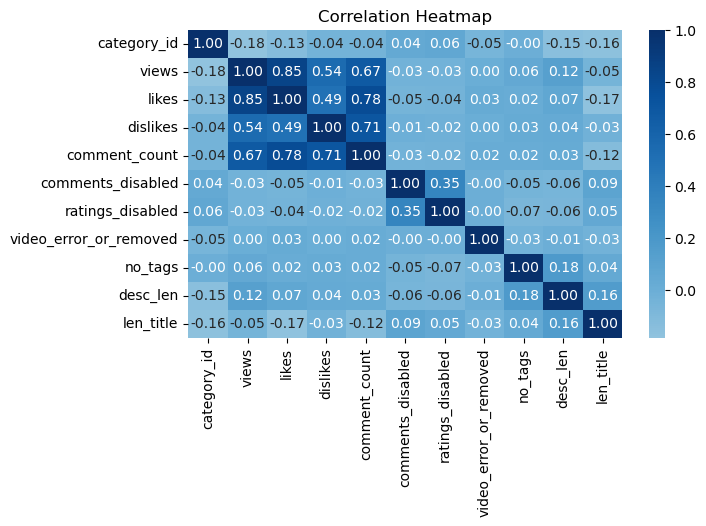

In [21]:
# Plot korelasi heatmap
corr_matrix = dfraw.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Berdasarkan grafik heatmap diatas, ada beberapa kesimpulan yang bisa kita tarik diantaranya:

* Fitur`likes` memiliki nilai korelasi yang tinggi (0.85).
* Selain `likes` ada `dislikes` dan `comment_count` yang memiliki nilai tinggi namun tidak masuk kedalam kategori redundan.  
* `dislikes` memiliki nilai korelasi 0.54 (positif korelasi) dimana semakin banyak suatu konten mendapat dislike maka bisa nilai dari views juga akan meningkat.  
* `comment_count` memiliki angka korelasi 0.67 dimana termasuk kedalam korelasi positif, sehingga semakin banyak suatu konten mendapat comments maka semakin tinggi pula angka views.  
* `comments_disabled` dan `ratings_disabled` juga menunjukkan korelasi yang lumayan baik.

### Korelasi Fitur Dengan Label

<Figure size 2400x800 with 0 Axes>

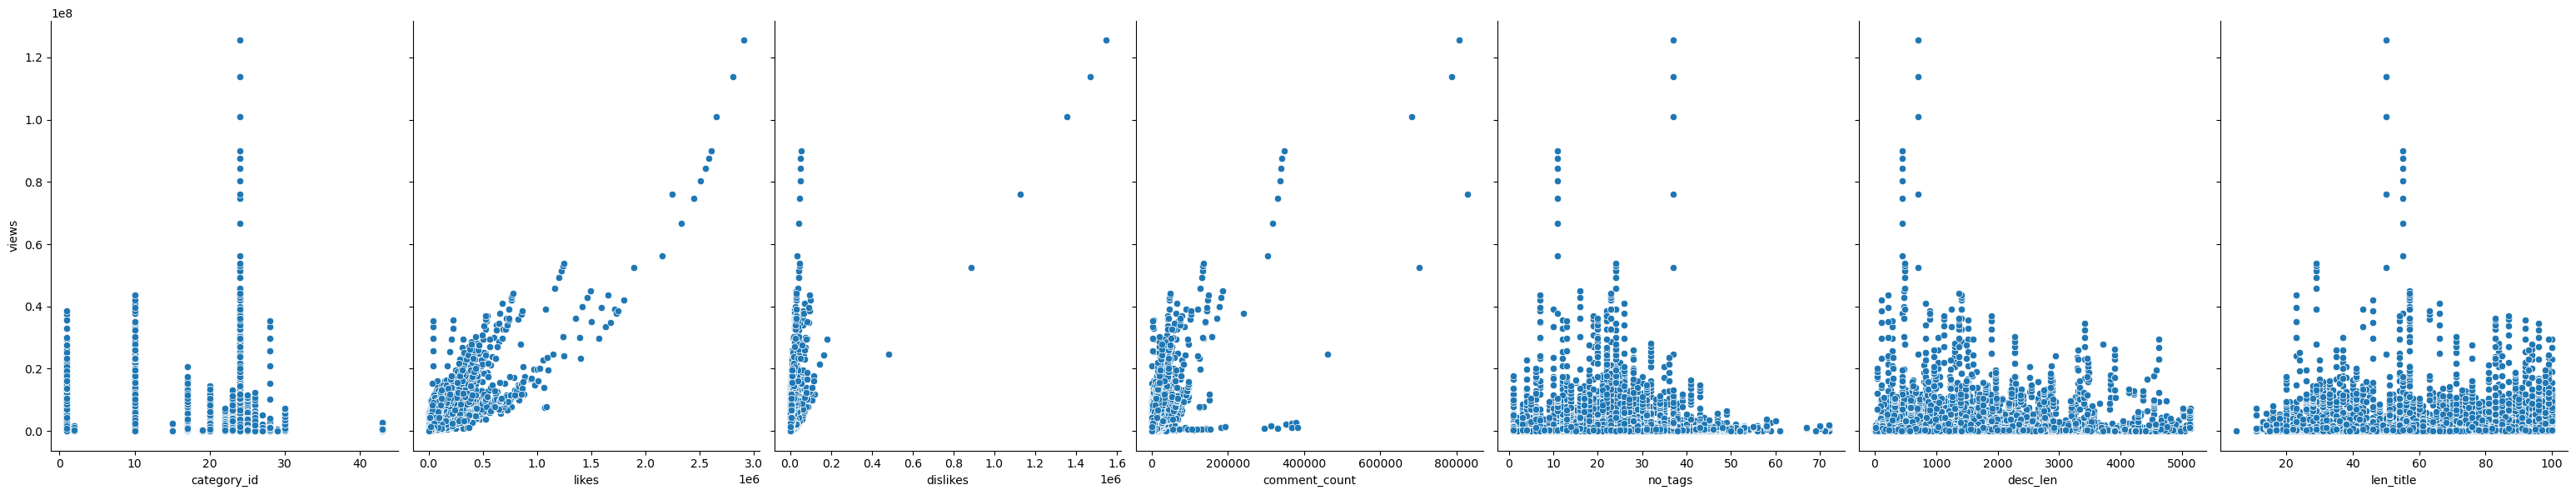

In [22]:
# Pairplot untuk melihat korelasi dengan label : views
plt.figure(figsize=(24,8))
fig = sns.pairplot(data=dfraw, x_vars=['category_id','likes','dislikes','comment_count','no_tags','desc_len','len_title'], y_vars=['views'], height=6, aspect=0.75);
fig.tight_layout();

Terlihat bahwa semakin tinggi views, maka semakin tinggi pula jumlah likes, dislikes, dan comment nya. Sedangkan untuk banyaknya tag, panjang deskripsi, dan panjang judul video kebanyakan jumlah nya merata namun cenderung hanya untuk views sekitar 0-2 juta.

### Korelasi Label Dengan Category

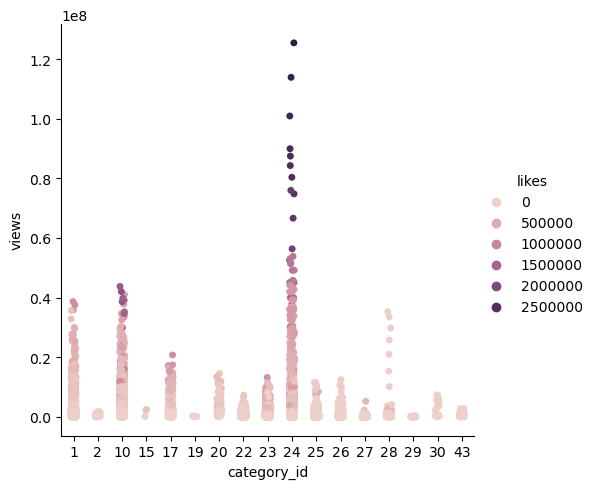

In [23]:
# Visualisasi Views Dengan Category_id

sns.catplot(data=dfraw, x='category_id', y='views', hue='likes')

Dari graph ini bisa kita simpulkan bahwa kategori konten yang memiliki jumlah views tinggi cenderung memiliki jumlah likes yang tinggi dan hanya beberapa konten saja yang dapat mendapatkan jumlah views yang terlampau tinggi dibanding dengan konten - konten lain.

### Korelasi Comment dan Category Terhadap Views

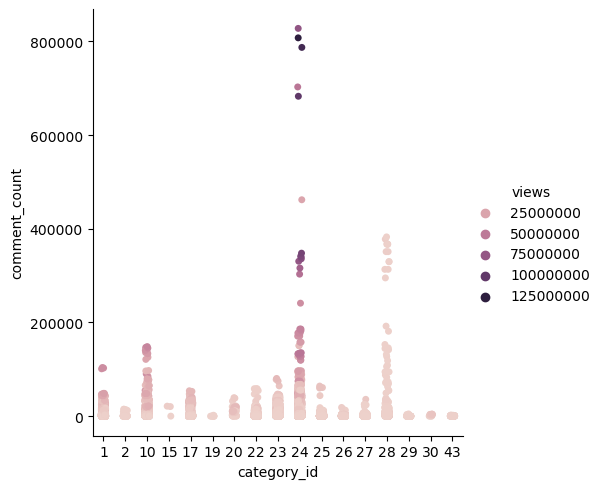

In [24]:
sns.catplot(data=dfraw, x='category_id', y='comment_count', hue='views')

Dari grafik ini dapat disimpulkan bahwa kategori konten mempengaruhi jumlah comment yang ada dan juga total views, sehingga hanya beberapa konten saja yang mendapatkan jumlah comments dan views yang melebihi rata-rata comments atau views.

### Korelasi Label Dengan Comment Disabled

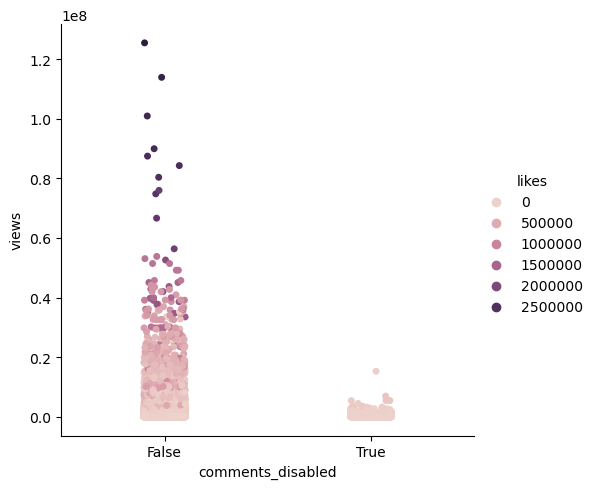

In [25]:
sns.catplot(data=dfraw, x='comments_disabled', y='views', hue='likes')

Dari grafik ini bisa disimpulkan bahwa konten dengan comment disable memiliki jumlah views yang rendah dan jumlah likes yang rendah pula.

-------

# Data Preparation

-----

## Data Cleaning

### Drop Columns

**Duplicated Rows**

Pada tahap Data Exploration sebelumnya, dataset tercatat memiliki 4229 data duplikat, sehingga kita harus menghapusnya.

In [26]:
# Menghapus duplicated rows
dfraw = dfraw.drop_duplicates(keep='first')

# Pengecekan kembali apakah masih terdapat duplikat atau tidak
print(f'Jumlah duplikat: {dfraw.duplicated().sum()}')

Jumlah duplikat: 0


**Irrelevant Features**

Beberapa fitur terlihat kurang relevan dan unique value yang dimiliki terlalu luas seperti yang sudah kita analisis sebelumnya. Sehingga diasumsikan bahwa fitur tersebut tidak memiliki pola tertentu. Fitur tersebut adalah `title`, `channel_title`, `publish_time`, `tags`, `description` yang akan dihapus.

In [27]:
dfraw = dfraw.drop(['title', 'channel_title', 'publish_time', 'tags', 'description'], axis=1)
dfraw.head(3)

,trending_date,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,no_tags,desc_len,len_title,publish_date
0,2017-11-14,1,1096327,33966,798,882,False,False,False,15,920,81,2017-11-12
1,2017-11-14,25,590101,735,904,0,True,False,False,19,2232,58,2017-11-13
2,2017-11-14,24,473988,2011,243,149,False,False,False,14,482,58,2017-11-12


### Missing Values

Sesuai yang telah disebutkan saat proses Data Exploration, data hilang (Null) hanya ditemukan pada kolom `description` meskipun hal tersebut masih dapat dikatakan masuk akal karena terkadang terdapat pemilik vidio yang tidak menuliskan apapun pada kolom deskripsi vidionya. Namun, karena kolom tersebut termasuk fitur yang irrelevant dan telah dihapus, maka tidak perlu menangani missing value.

### Handling Outliers

In [28]:
df_cleansing = dfraw.copy()

In [29]:
def outlier_del(df, column, mode):
    q1 = df.iloc[:,column].quantile(0.25)
    q3 = df.iloc[:,column].quantile(0.75)
    iqr = q3-q1
    lower_tail = q1 - (1.5 * iqr)
    upper_tail = q3 + (1.5 * iqr)
    nama_kolom = df.columns[column]
    jumlah_outliers = df[(df.iloc[:,column] <= lower_tail)|(df.iloc[:,column] >= upper_tail)].iloc[:,column].count()
    total_row = df.iloc[:,column].count()
    persentase_outliers = round(((jumlah_outliers/total_row)*100),2)
    if mode == 'summary':
        return print('Jumlah Outliers pada kolom ', nama_kolom, ' :', jumlah_outliers, ' dan persentase outliers:', persentase_outliers, '%')
    elif mode == 'df':
        return df[(df.iloc[:,column] >= lower_tail)&(df.iloc[:,column] <= upper_tail)]
    else :
        return print('periksa mode yang diinputkan')

In [30]:
column = [2, 3, 4, 5, 9, 10, 11]

for i in range(0, len(column)):
    outlier_del(df_cleansing, column[i], 'summary')

Jumlah Outliers pada kolom  views  : 3733  dan persentase outliers: 11.46 %
Jumlah Outliers pada kolom  likes  : 4955  dan persentase outliers: 15.22 %
Jumlah Outliers pada kolom  dislikes  : 3899  dan persentase outliers: 11.97 %
Jumlah Outliers pada kolom  comment_count  : 4222  dan persentase outliers: 12.97 %
Jumlah Outliers pada kolom  no_tags  : 400  dan persentase outliers: 1.23 %
Jumlah Outliers pada kolom  desc_len  : 1604  dan persentase outliers: 4.93 %
Jumlah Outliers pada kolom  len_title  : 0  dan persentase outliers: 0.0 %


seperti yang juga telah dinyatakan saat Data Exploration bahwa terdapat banyak sekali outlier, selanjutnya akan dilakukan penghapusan outlier pada kolom-kolom yang memiliki outlier dibawah 5% yaitu kolom `no_tags` dan `desc_len`.

In [31]:
# Penghapusan Outlier
df_cleansing = df_cleansing[df_cleansing.index.isin(outlier_del(dfraw, 9, 'df').reset_index()['index'])]
df_cleansing = df_cleansing[df_cleansing.index.isin(outlier_del(dfraw, 10, 'df').reset_index()['index'])]
df_cleansing.shape

(30567, 13)

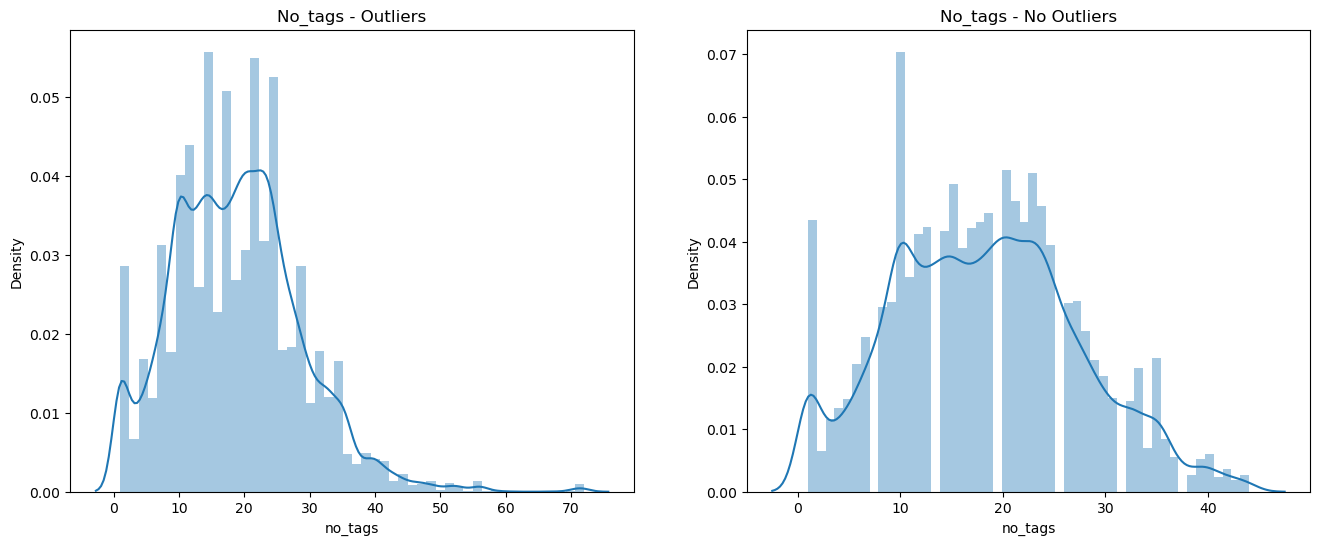

In [32]:
# Membuat Plot Untuk Membandingkan dengan kondisi sebelum penghapusan outlier
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(dfraw.no_tags)
plt.title('No_tags - Outliers')
plt.subplot(1, 2, 2)
sns.distplot(df_cleansing.no_tags)
plt.title('No_tags - No Outliers')
plt.show()

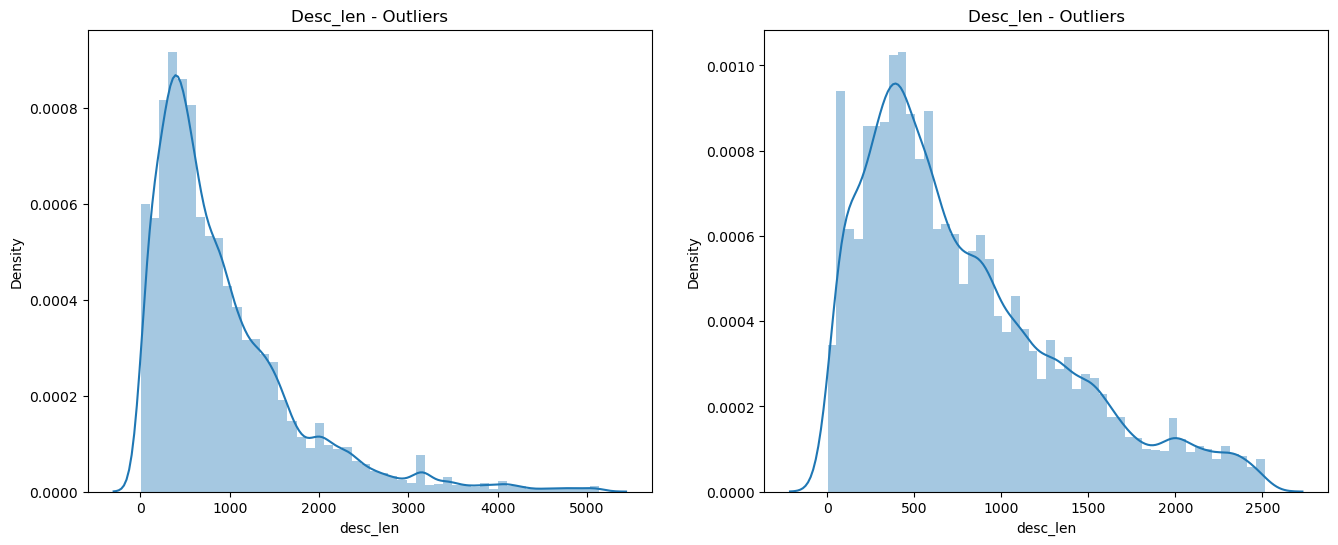

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(dfraw.desc_len)
plt.title('Desc_len - Outliers')
plt.subplot(1, 2, 2)
sns.distplot(df_cleansing.desc_len)
plt.title('Desc_len - Outliers')
plt.show()

## Data Preparation

### Feature Engineering

Feature engineering yang dilakukan adalah menambahkan fitur baru yaitu is_weekend, yang mengecek apakah sebuah video yang dipublish di weekend memberikan dampak yang signifikan.

In [34]:
df_cleansing['publish_date'] = df_cleansing['publish_date'].astype(str)
df_cleansing['publish_date'].head()

0    2017-11-12
1    2017-11-13
2    2017-11-12
3    2017-11-12
4    2017-11-13
Name: publish_date, dtype: object

In [35]:
timeget = []
for i in df_cleansing['publish_date'].str.split():
    time_split = i[:5]
    date_string = ' '.join(time_split)
    timeget.append(date_string)

In [36]:
df_cleansing['publish_date'] =  pd.to_datetime(timeget)
df_cleansing['day_of_week'] = df_cleansing['publish_date'].apply(lambda time: time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [37]:
def is_weekend(dmap):
    if dmap.weekday() < 5:
        return False
    else:
        return True
df_cleansing['is_weekend'] = df_cleansing['publish_date'].apply(is_weekend)

df_cleansing.head()

,trending_date,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,no_tags,desc_len,len_title,publish_date,day_of_week,is_weekend
0,2017-11-14,1,1096327,33966,798,882,False,False,False,15,920,81,2017-11-12,6,True
1,2017-11-14,25,590101,735,904,0,True,False,False,19,2232,58,2017-11-13,0,False
2,2017-11-14,24,473988,2011,243,149,False,False,False,14,482,58,2017-11-12,6,True
3,2017-11-14,23,1242680,70353,1624,2684,False,False,False,20,263,30,2017-11-12,6,True
4,2017-11-14,24,464015,492,293,66,False,False,False,11,753,88,2017-11-13,0,False


### Log Transformation

Dikarenakan persebaran data yang kita miliki sangat tidak normal, maka kita akan melakukan transformasi fitur. Jika outliers pada fitur `no_tags` dan `desc_len` dihapus, maka untuk outliers pada fitur-fitur yang lain akan ditangani dengan menggunakan Log Transformation. Kita bisa menggunakan Log Transformation sehingga distribusi data mendekati Gaussian.

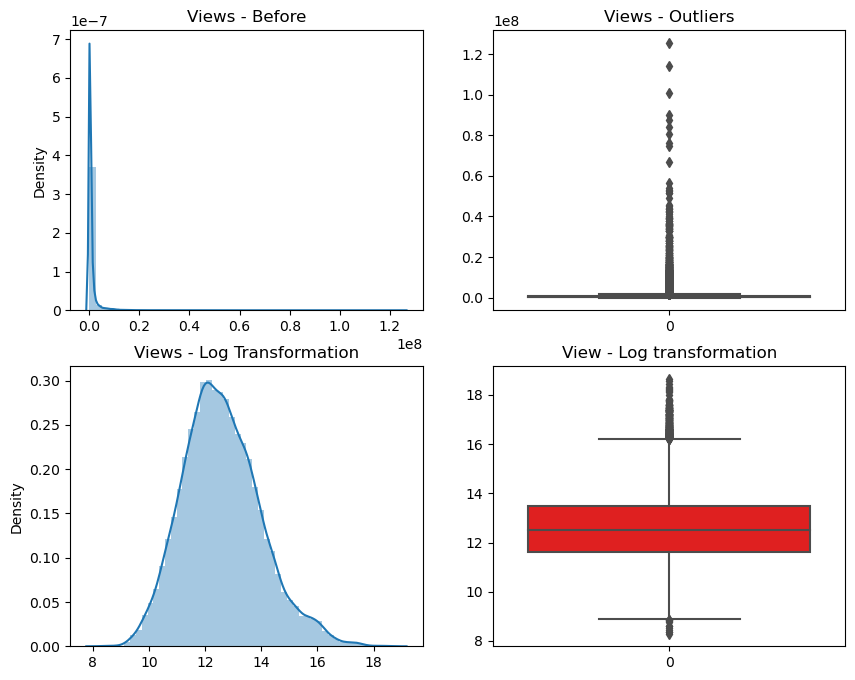

In [38]:
# Log Transformation for Views

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Plotting
g = sns.distplot(df_cleansing['views'],kde=True, ax=ax[0,0])
ax[0,0].set_title('Views - Before')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_cleansing['views'],color='red',orient='v', ax=ax[0,1])
ax[0,1].set_title('Views - Outliers')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_cleansing['views']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('Views - Log Transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_cleansing['views']+1),color='red',orient='v', ax=ax[1,1])
ax[1,1].set_title('View - Log transformation')
ax[1,1].set_xlabel('')

plt.show()

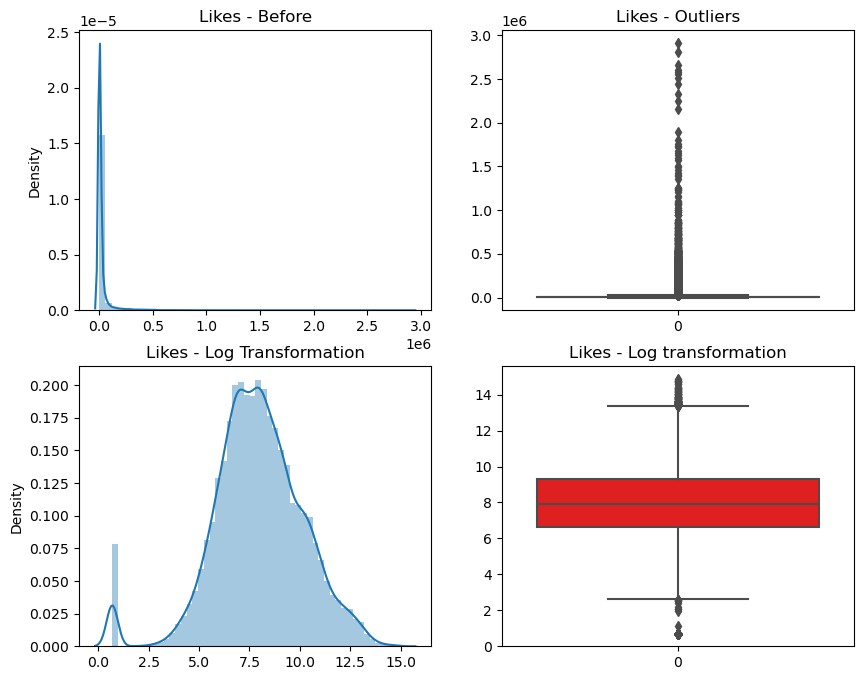

In [39]:
# Log Transformation for Likes

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Plotting
g = sns.distplot(df_cleansing['likes'],kde=True, ax=ax[0,0])
ax[0,0].set_title('Likes - Before')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_cleansing['likes'],color='red',orient='v', ax=ax[0,1])
ax[0,1].set_title('Likes - Outliers')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_cleansing['likes']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('Likes - Log Transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_cleansing['likes']+1),color='red',orient='v', ax=ax[1,1])
ax[1,1].set_title('Likes - Log transformation')
ax[1,1].set_xlabel('')

plt.show()

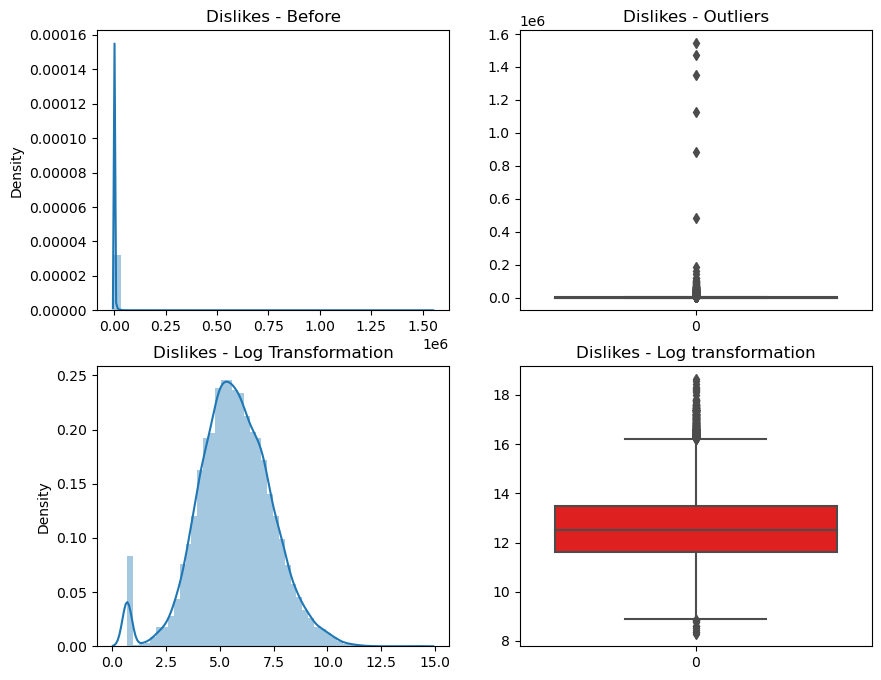

In [40]:
# Log Transformation for Dislikes

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Plotting
g = sns.distplot(df_cleansing['dislikes'],kde=True, ax=ax[0,0])
ax[0,0].set_title('Dislikes - Before')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_cleansing['dislikes'],color='red',orient='v', ax=ax[0,1])
ax[0,1].set_title('Dislikes - Outliers')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_cleansing['dislikes']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('Dislikes - Log Transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_cleansing['views']+1),color='red',orient='v', ax=ax[1,1])
ax[1,1].set_title('Dislikes - Log transformation')
ax[1,1].set_xlabel('')

plt.show()

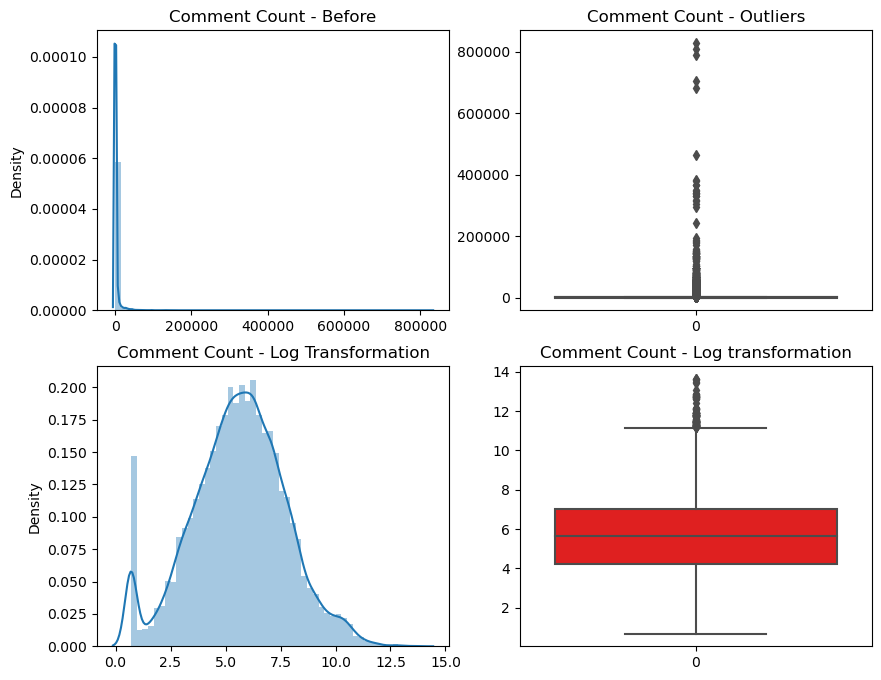

In [41]:
# Log Transformation for Comment Count

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Plotting
g = sns.distplot(df_cleansing['comment_count'],kde=True, ax=ax[0,0])
ax[0,0].set_title('Comment Count - Before')
ax[0,0].set_xlabel('')

g = sns.boxplot(df_cleansing['comment_count'],color='red',orient='v', ax=ax[0,1])
ax[0,1].set_title('Comment Count - Outliers')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(df_cleansing['comment_count']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('Comment Count - Log Transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(df_cleansing['comment_count']+1),color='red',orient='v', ax=ax[1,1])
ax[1,1].set_title('Comment Count - Log transformation')
ax[1,1].set_xlabel('')

plt.show()

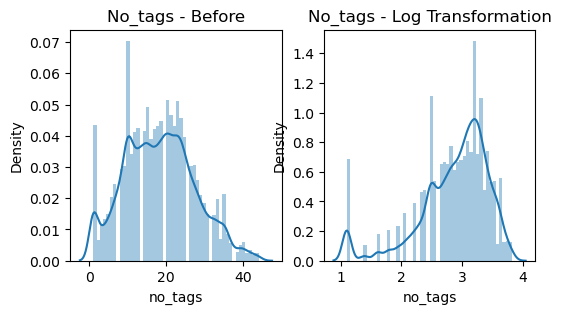

In [42]:
# Log Transformation for No Tags

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plotting
g = sns.distplot(df_cleansing['no_tags'],kde=True, ax=ax1)
ax1.set_title('No_tags - Before')

g = sns.distplot(np.log1p(df_cleansing['no_tags']+1),kde=True, ax=ax2)
ax2.set_title('No_tags - Log Transformation')

plt.show()

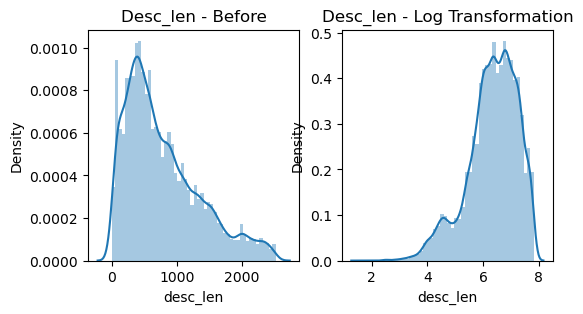

In [43]:
# Log Transformation for Desc Len

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plotting
g = sns.distplot(df_cleansing['desc_len'],kde=True, ax=ax1)
ax1.set_title('Desc_len - Before')

g = sns.distplot(np.log1p(df_cleansing['desc_len']+1),kde=True, ax=ax2)
ax2.set_title('Desc_len - Log Transformation')

plt.show()

In [44]:
s_features = ['category_id','views','likes','dislikes','comment_count','no_tags','desc_len','len_title']

df = df_cleansing.copy()
for var in s_features:
    df['log_'+var]= (df_cleansing[var]+1).apply(np.log)

In [45]:
df = df.drop(['day_of_week'], axis=1)
df.columns

Index(['trending_date', 'category_id', 'views', 'likes', 'dislikes',
       'comment_count', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'no_tags', 'desc_len', 'len_title',
       'publish_date', 'is_weekend', 'log_category_id', 'log_views',
       'log_likes', 'log_dislikes', 'log_comment_count', 'log_no_tags',
       'log_desc_len', 'log_len_title'],
      dtype='object')

Setelah data terdistribusi secara lebih normal, maka selanjutny adalah melakukan train dan test split data.

## Train & Test Split

In [46]:
X = df[['log_category_id','log_likes','log_dislikes','log_comment_count','log_no_tags','log_desc_len','log_len_title','is_weekend','comments_disabled', 'ratings_disabled','video_error_or_removed']]
y = df[['log_views']]

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [48]:
# Membuat data train dan data test
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

Untuk mencegah terjadinya data leak, maka normalisasi dilakukan setelah train test split.

## Pre-Processing

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
std_train = scaler.fit_transform(data_train)
std_test = scaler.transform(data_test)

# Mengembalikan nilai ke dataframe
std_train = pd.DataFrame(std_train, columns=data_train.columns)
std_test = pd.DataFrame(std_test, columns=data_test.columns)

In [50]:
Xtrain_std = std_train.drop('log_views', axis=1)
ytrain_std = std_train.log_views
Xtest_std = std_test.drop('log_views', axis=1)
ytest_std = std_test.log_views

-------

# Modelling and Evaluation

------

## Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(Xtrain_std, ytrain_std)

LinearRegression()

In [52]:
y_pred = regressor.predict(Xtest_std)
y_pred

array([0.47877314, 0.35778994, 0.30361186, ..., 0.50590419, 0.41537863,
       0.5186904 ])

Seperti semua fungsi NumPy yang dirancang untuk melakukan perhitungan ini dengan array dan struktur array-like.

e adalah konstanta matematika yang disebut bilangan Euler, kira-kira 2,718281. Nilai ini memiliki hubungan matematis yang erat dengan pi dan the slope of the curve e^x sama dengan nilainya di setiap titik.

Maka, fungsi np.exp berguna saat kita perlu menghitung e^x untuk matriks angka yang besar atau mengembalikan fungsi log ke base e (Euler's number).

In [53]:
# np.exp function transformation
## Mengembalikan fungsi log ke base e
np.exp(y_pred).round()

array([2., 1., 1., ..., 2., 2., 2.])

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_regression(model, y_pred, Xtrain_std, Xtest_std, ytrain_std,  ytest_std):
    print("MAE: " , mean_absolute_error(ytest_std, y_pred))
    print("RMSE: " , mean_squared_error(ytest_std, y_pred, squared=False))
    print('R2 score: ', r2_score(ytest_std, y_pred))
    print('Coefficients: ', regressor.coef_)
    print('Intercept: ', regressor.intercept_)

eval_regression(regressor, y_pred, Xtrain_std, Xtest_std, ytrain_std, ytest_std)

MAE:  0.04999793627638229
RMSE:  0.0635529708431074
R2 score:  0.7822832006798476
Coefficients:  [-0.03420802  0.35620518  0.92604649 -0.21842657  0.00590794  0.02773533
  0.03752948 -0.00549904 -0.09187015  0.48185677 -0.03013817]
Intercept:  -0.08779262204614907


-----

## Decision Tree Regression

In [55]:
from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(Xtrain_std, ytrain_std)

DecisionTreeRegressor()

In [56]:
y_pred = dt_regressor.predict(Xtest_std)
y_pred

array([0.32942986, 0.36460215, 0.33329321, ..., 0.54106551, 0.47266795,
       0.40316092])

In [57]:
# Evaluasi Decision Tree Regression
eval_regression(dt_regressor, y_pred, Xtrain_std, Xtest_std, ytrain_std, ytest_std)

MAE:  0.04404707446602339
RMSE:  0.06297136860812533
R2 score:  0.7862498186290703
Coefficients:  [-0.03420802  0.35620518  0.92604649 -0.21842657  0.00590794  0.02773533
  0.03752948 -0.00549904 -0.09187015  0.48185677 -0.03013817]
Intercept:  -0.08779262204614907


---

## Random Forest Regression

### Tuning Hyperparameter

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)], # Jumlah subtree
                       criterion = ['squared_error','absolute_error'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 5)],  # Maximum kedalaman tree
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf_reg = RandomForestRegressor(random_state=42)
rf_tuned = RandomizedSearchCV(rf_reg, hyperparameters, cv=5, random_state=42, scoring='r2')
rf_tuned.fit(Xtrain_std, ytrain_std)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [10, 35, 60, 85, 110],
                                        'n_estimators': [100, 111, 122, 133,
                                                         144, 155, 166, 177,
                                                         188, 200],
                                        'n_jobs': [-1]},
                   random_state=42, scoring='r2')

In [60]:
def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 200
Best criterion: squared_error
Best max_depth: 85
Best n_jobs: -1


In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=85, random_state=42, n_jobs=-1)
rf_regressor.fit(Xtrain_std, ytrain_std)

RandomForestRegressor(max_depth=85, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [63]:
y_pred = rf_regressor.predict(Xtest_std)
y_pred

array([0.48178693, 0.33315213, 0.29385941, ..., 0.5109871 , 0.45753415,
       0.47635983])

In [64]:
# Evaluasi Random Forest Regression
eval_regression(rf_regressor, y_pred, Xtrain_std, Xtest_std, ytrain_std, ytest_std)

MAE:  0.032668543173624005
RMSE:  0.044236163792310344
R2 score:  0.8945187804814067
Coefficients:  [-0.03420802  0.35620518  0.92604649 -0.21842657  0.00590794  0.02773533
  0.03752948 -0.00549904 -0.09187015  0.48185677 -0.03013817]
Intercept:  -0.08779262204614907


---

## XG Boost

In [69]:
!pip install -U hgboost

     ---------------------------------------- 1.3/1.3 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 200.5/200.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2970 sha256=960772d17f83f91266e9831421c6248a9db3378f5d950678cd56b8977e9c4a61
  Stored in directory: c:\users\myasu\appdata\local\pip\cache\wheels\8e\21\72\6e096fe9f5263038bd31fdf055d8e30f117956f015faba3c06
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=c54fdf25777385193c4c0604832f528a7899a3f2485be956c389188e89b5f643
  Stored in directory: c:\users\myasu\appdata\local\pip\cache\wheels\46\78\0e\8e5e2b500f83a682c8d7e7ce820638cf99faa894a662f71cf0
Succ

### Tuning Hyperparameter

In [70]:
from hgboost import hgboost

# Initialize library.
hgb = hgboost(
    max_eval=1000,      # Search space is based  on the number of evaluations.
    threshold=0.5,     # Classification threshold. In case of two-class model this is 0.5.
    cv=5,              # k-folds cross-validation.
    test_size=0.2,     # Percentage split for the testset.
    val_size=0.2,      # Percentage split for the validationset.
    top_cv_evals=10,   # Number of top best performing models that is evaluated.
#     is_unbalance=True, # Control the balance of positive and negative weights, useful for unbalanced classes.
    random_state=42, # Fix the random state to create reproducible results.
    n_jobs=-1,         # The number of CPU jobs to run in parallel. -1 means using all processors.
    gpu=False,         # Compute using GPU in case of True.
    verbose=3,         # Print progress to screen.
)

In [74]:
xgb_reg_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7 ],
        'eta' : [0.1,0.01, 0.05],
        'n_estimators' : [100, 200, 400,600]
}

results  = hgb.xgboost_reg(X, np.array(y), eval_metric='rmse')

[hgboost] >Start hgboost regression.
[hgboost] >Collecting xgb_reg parameters.
[hgboost] >method: xgb_reg
[hgboost] >eval_metric: rmse
[hgboost] >greater_is_better: False
[hgboost] >*********************************************************************************
[hgboost] >Total dataset: (30567, 11) 
[hgboost] >Validation set: (6114, 11) 
[hgboost] >Test-set: (6114, 11) 
[hgboost] >Train-set: (18339, 11) 
[hgboost] >*********************************************************************************
[hgboost] >Searching across hyperparameter space for best performing parameters using maximum nr. evaluations: 1000
100%|██████████████████████████████████████████| 1000/1000 [1:31:10<00:00,  5.47s/trial, best loss: 0.3831702780990879]
[hgboost]> Collecting the hyperparameters from the [1000] trials.
[hgboost] >[rmse]: 0.3832 Best performing model across 1000 iterations using Bayesian Optimization with Hyperopt.
[hgboost] >**********************************************************************

In [75]:
# Results are stored in the object and can be found in:
print(hgb.results)

# Results are also returned by the model:
print(results.keys())

# The params contains the parameters to create the best performing model.
print(results['params'])

{'params': {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 27, 'min_child_weight': 3, 'n_estimators': 140, 'reg_lambda': 5.0, 'subsample': 0.9372281985419406}, 'summary':      gamma gpu_id learning_rate max_depth min_child_weight n_estimators  \
0    0.250      0         0.250        16                3          165   
1    0.500      0         0.250        11                8           85   
2    0.250      0         0.200        29                1           95   
3    1.000      0         0.150        17                9           60   
4    1.000      0         0.250        25                9          175   
...    ...    ...           ...       ...              ...          ...   
996      0      0         0.100        15                3           45   
997      0      0         0.150        12                3          155   
998  0.500      0         0.050        20                2          180   
999      0      0         0.100        27                5           60   
1000

In [76]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(gamma=0, learning_rate=0.1, max_depth=27, min_child_weight=3, n_estimators=140, reg_lambda=5.0, subsample=0.93)
xgb_regressor.fit(Xtrain_std, ytrain_std)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=27, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=140, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [77]:
y_pred = xgb_regressor.predict(Xtest_std)
y_pred

array([0.48306486, 0.3456601 , 0.32120097, ..., 0.5091979 , 0.46092904,
       0.46974015], dtype=float32)

In [78]:
# Evaluasi Gradient Boosting Regression
eval_regression(xgb_regressor, y_pred, Xtrain_std, Xtest_std, ytrain_std, ytest_std)

MAE:  0.028627825198384485
RMSE:  0.04037818781483298
R2 score:  0.9121151785162508
Coefficients:  [-0.03420802  0.35620518  0.92604649 -0.21842657  0.00590794  0.02773533
  0.03752948 -0.00549904 -0.09187015  0.48185677 -0.03013817]
Intercept:  -0.08779262204614907


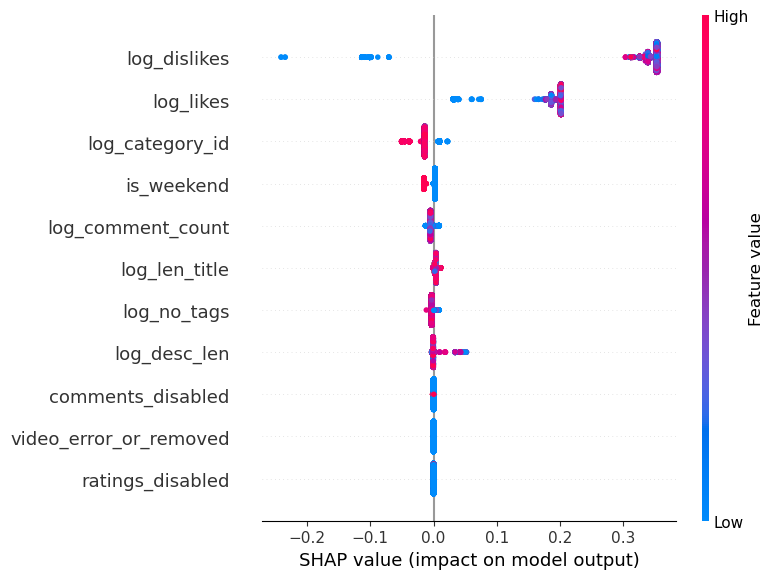

In [79]:
import shap
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

----------

# Kesimpulan

1. Dari hasil pemodelan yang telah dilakukan terhadap dataset Statistik Youtube untuk memprediksi jumlah views, kita bisa menyimpulkan bahwa model terbaik yaitu XG Boost yang memberikan R2 Score : 0.91 serta nilai MAE dan RMSE yang kecil yaitu 0.02 dan 0.04. Artinya model menunjukkan performa yang baik dalam memprediksi target.  

2. Model terbaik kedua adalah model Random Forest dengan R2 Score : 0.89 serta nilai MAE dan RMSE yang tidak jauh berbeda dari model XG Boost, yaitu : 0.03 dan 0.04.  

3. Rekomendasi bisnis yang bisa diberikan untuk meningkatkan jumlah views adalah  :  
    * Bisa memanfaatkan waktu publish, yaitu di hari weekend dimana hal tersebut memberikan pengaruh dalam peningkatan jumlah views.  Jika hal ini dilakukan, kemungkinan besar kita akan memperoleh hasil yang signifikan yaitu :  
        a. Jumlah views bertambah  
        b. Jika jumlah views bertambah, otomatis jumlah likes, dislikes, maupun comment akan meningkat.  
        c. Jika hal tersebut semakin banyak, maka algoritma Youtube akan mendeteksi video sebagai video trending.
    * Tidak membatas komen dan rating. Dari hasil analisa data terlihat bahwa jika video membatasi komen dan rating, maka minat seseorang untuk menonton video tersebut juga akan berkurang, sehingga jumlah interaksi dengan video juga akan berkurang.
    * Kategori konten juga mempengaruhi jumlah views. Posting lah konten-konten yang sering disukai oleh penonton, lalu sesuaikan tag (baik judul tag maupun jumlah tag) dengan proporsi yang bagus.